# Time Series Analysis with Facebook Prophet
## Additive Models for Time Series Modeling

![clock1](http://www.yankodesign.com/images/design_news/2015/03/18/pinclock_04.jpg) 
![clock2](http://uploads.neatorama.com/images/posts/307/64/64307/1376759653-0.jpg)

Time series are one of the most common data types encountered in daily life. Financial prices, weather, home energy usage, and even weight are all examples of data that can be collected at regular intervals. Almost every data scientist will encounter time series in their daily work and learning how to model them is an important skill in the data science toolbox. One powerful yet simple method for analyzing and predicting periodic data is the additive model. The idea is straightforward: represent a time-series as a combination of patterns at different scales such as daily, weekly, seasonally, and yearly, along with an overall trend. Your energy use might rise in the summer and decrease in the winter, but have an overall decreasing trend as you increase the energy efficiency of your home. An additive model can show us both patterns/trends and make predictions based on these observations.

The following image shows an additive model decomposition of a time-series into an overall trend, yearly trend, and weekly trend.

![additive model](https://cdn-images-1.medium.com/max/1000/1*p5l_eKG4we5d8GDzC6o_gg.png)

This Jupyter Notebook will walk through an introductory example of creating an additive model for time-series data regarding ride sharing price estimates using Python and the Prophet forecasting package developed by Facebook. Along the way, we will cover some data manipulation using pandas and plotting with matplotlib. This introduction will show you all the steps needed to start modeling time-series on your own!

## Contents
- [Retrieving the Data](#Retrieving-the-Data)

- [Modeling with Prophet](#Modeling-with-Prophet)

- [Making Future Dataframes](#Making-Future-Dataframes)

- [Changepoint Prior Scaling](#Changepoint-Prior-Scaling)

- [Trends and Patterns](#Trends-and-Patterns)

- [Conclusion](#Conclusion)

### Retrieving the Data

Usually, about 80% of the time spent on a data science project is getting and cleaning data. But thankfully for you readers the data we need is up on __[Mandy Yang's GitHub](https://github.com/MandyYang86/Ride-Optimization/tree/master/Merge%20Data)__.

First, we import the required libraries and read the data with pandas' read_csv function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

The pandas dataframe is formed and it is the data structure of __*CHOICE*__ for data science.

In [2]:
df1 = pd.read_csv('https://raw.githubusercontent.com/MandyYang86/Ride-Optimization/master/Merge%20Data/uber_pool_March.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/MandyYang86/Ride-Optimization/master/Merge%20Data/lyft_line_March.csv')

Here with the .head function of pandas we can look at the first first rows of uberPOOL's data in March. The explanation of each column headings is available in README.md file.

In [3]:
df1.head()

,date_time,date,day,uber_distance,uber_duration,uber_estimate,uber_high_estimate,uber_low_estimate,main_temp,time,weather,uber_price_per_second
0,2018-03-01 00:00:03,1-Mar-18,Thursday,1.73,360,7.5,9.0,6.0,46.69,0:00:03,Rain,0.020833
1,2018-03-01 00:01:03,1-Mar-18,Thursday,1.90,480,5.5,7.0,4.0,46.69,0:01:03,Rain,0.011458
2,2018-03-01 00:02:03,1-Mar-18,Thursday,2.26,420,7.0,9.0,5.0,46.56,0:02:03,Rain,0.016667
3,2018-03-01 00:03:02,1-Mar-18,Thursday,1.63,360,7.5,9.0,6.0,46.56,0:03:02,Rain,0.020833
4,2018-03-01 00:04:02,1-Mar-18,Thursday,2.17,480,9.5,11.0,8.0,46.56,0:04:02,Rain,0.019792


In [4]:
df1.columns

Index(['date_time', 'date', 'day', 'uber_distance', 'uber_duration',
       'uber_estimate', 'uber_high_estimate', 'uber_low_estimate', 'main_temp',
       'time', 'weather', 'uber_price_per_second'],
      dtype='object')

In [5]:
df2.head()

,date_time,date,day,lyft_distance,lyft_duration,time,lyft_max_estimate,lyft_min_estimate,lyft_estimate,lyft_price_per_second
0,2018-03-01 00:00:03,1-Mar-18,Thursday,1.76,414,0:00:03,3.40,3.40,3.40,0.008213
1,2018-03-01 00:01:03,1-Mar-18,Thursday,1.79,537,0:01:03,3.53,3.53,3.53,0.006574
2,2018-03-01 00:02:03,1-Mar-18,Thursday,2.20,487,0:02:03,3.85,3.85,3.85,0.007906
3,2018-03-01 00:03:02,1-Mar-18,Thursday,1.70,472,0:03:02,3.46,3.46,3.46,0.007331
4,2018-03-01 00:04:02,1-Mar-18,Thursday,2.21,553,0:04:02,3.47,3.47,3.47,0.006275


In [6]:
# setting date_time column as the datetimeindex
df1 = df1.set_index(pd.DatetimeIndex(df1['date_time']))
df2 = df2.set_index(pd.DatetimeIndex(df1['date_time']))

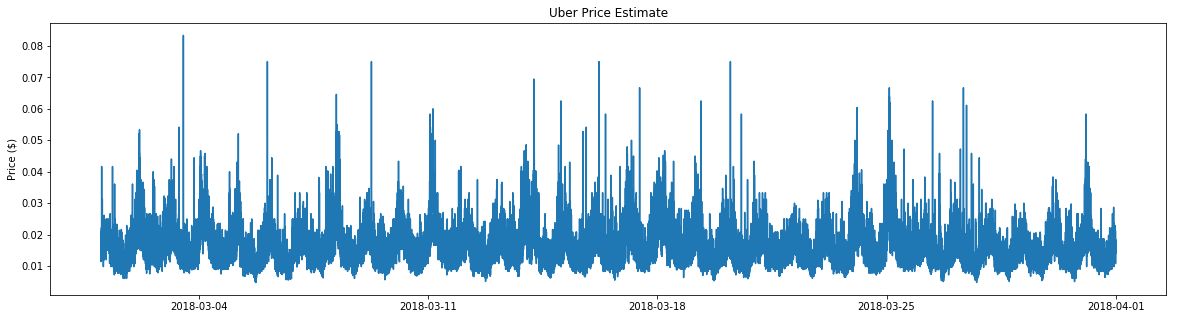

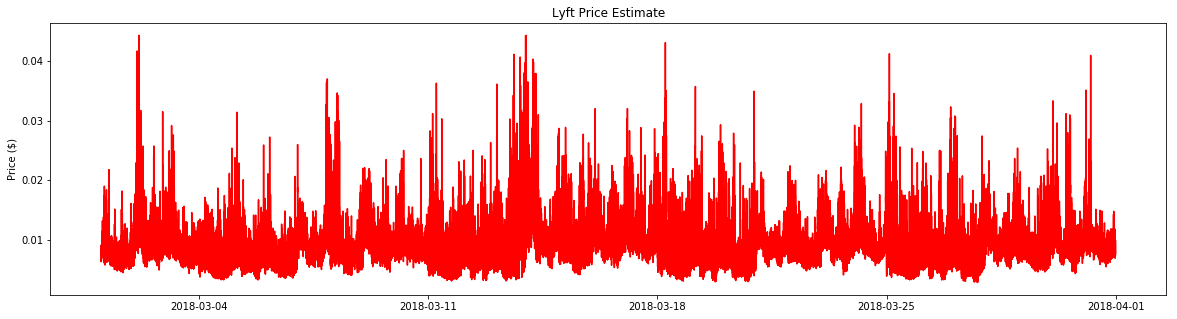

In [7]:
plt.rcParams["figure.figsize"] = (20, 5)              # setting the plot size
plt.plot(df1.index, df1['uber_price_per_second'])     # plotting datetimeindex as x-axis, price as y-axis
plt.title('Uber Price Estimate')                      # setting the title
plt.ylabel('Price ($)')                               # labeling the y axis
plt.show()

plt.plot(df2.index, df2['lyft_price_per_second'], 'r')
plt.title('Lyft Price Estimate')
plt.ylabel('Price ($)')
plt.show()

In [8]:
# Merged Uber and Lyft datasets
df = pd.read_csv('https://raw.githubusercontent.com/MandyYang86/Ride-Optimization/master/Merge%20Data/uber_lyft_March.csv')

In [9]:
df.head()

,date_time,uber_distance,uber_duration,uber_estimate,uber_high_estimate,uber_low_estimate,main_temp,weather,uber_price_per_second,lyft_distance,lyft_duration,lyft_max_estimate,lyft_min_estimate,lyft_estimate,lyft_price_per_second,average_duration
0,3/1/18 0:00,1.73,360,7.5,9,6,46.69,Rain,0.019380,1.76,414,3.40,3.40,3.40,0.008786,387.0
1,3/1/18 0:01,1.90,480,5.5,7,4,46.69,Rain,0.010816,1.79,537,3.53,3.53,3.53,0.006942,508.5
2,3/1/18 0:02,2.26,420,7.0,9,5,46.56,Rain,0.015436,2.20,487,3.85,3.85,3.85,0.008490,453.5
3,3/1/18 0:03,1.63,360,7.5,9,6,46.56,Rain,0.018029,1.70,472,3.46,3.46,3.46,0.008317,416.0
4,3/1/18 0:04,2.17,480,9.5,11,8,46.56,Rain,0.018393,2.21,553,3.47,3.47,3.47,0.006718,516.5


### Modeling with Prophet

The Facebook Prophet package was released in 2017 for Python and R, and data scientists around the world rejoiced. Prophet is designed for analyzing time series with daily observations that display patterns on different time scales. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. 

We first import prophet and rename the columns in our data to the correct format. The Date column __must__ be called ‘ds’ and the value column we want to predict ‘y’. We then create prophet models and fit them to the data, much like a Scikit-Learn machine learning model.

In [10]:
df.rename(columns={'date_time': 'ds'}, inplace=True) # renaming column to ds

In [11]:
# Select only the relevant columns for forecasting
df = df.ix[:, ['ds', 'uber_price_per_second', 'lyft_price_per_second']]

df.head()

C:\Users\Maxx\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


,ds,uber_price_per_second,lyft_price_per_second
0,3/1/18 0:00,0.019380,0.008786
1,3/1/18 0:01,0.010816,0.006942
2,3/1/18 0:02,0.015436,0.008490
3,3/1/18 0:03,0.018029,0.008317
4,3/1/18 0:04,0.018393,0.006718


In [12]:
# converting ds to datetime
df.ds = pd.to_datetime(df.ds)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44434 entries, 0 to 44433
Data columns (total 3 columns):
ds                       44434 non-null datetime64[ns]
uber_price_per_second    44434 non-null float64
lyft_price_per_second    44434 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.0 MB


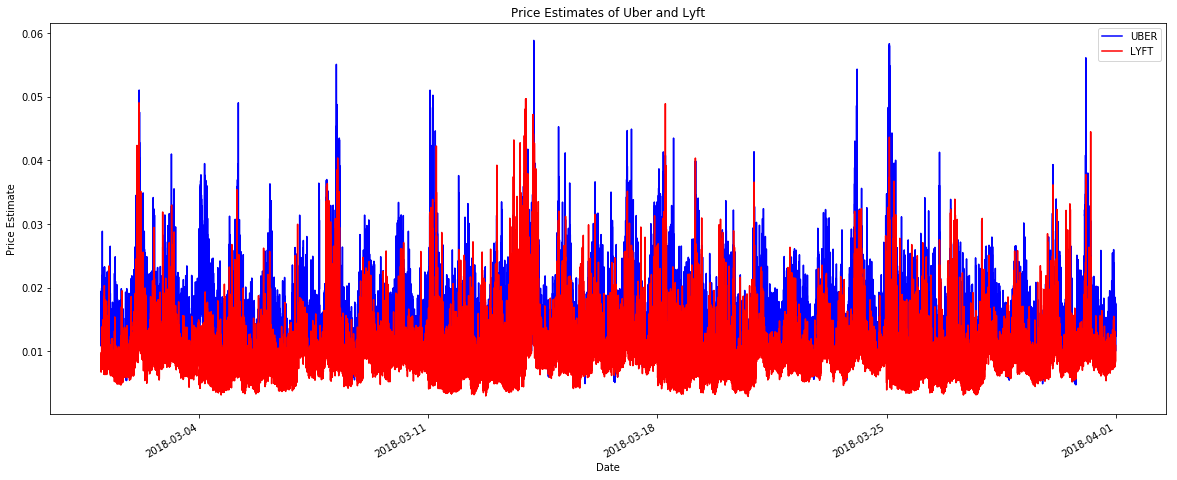

In [16]:
plt.rcParams["figure.figsize"] = (20, 8) # setting plot size
plt.plot(df['ds'], df['uber_price_per_second'], 'b-', label = 'UBER') # plotting ds as x-axis, price as y-axis
plt.plot(df['ds'], df['lyft_price_per_second'], 'r-', label = 'LYFT') # color blue and red line respectively
plt.xlabel('Date') # labeling x-axis label
plt.ylabel('Price Estimate') # labeling y-axis label
plt.title('Price Estimates of Uber and Lyft') # labeling plot title
# get a reference to the current figure and autoformatting the date in the x-axis to be more reader-friendly
plt.gcf().autofmt_xdate() 
plt.legend() # setting legend

In [17]:
# Find the first and last time lyft price estimate was higher than uber
first_date = df.ix[np.min(list(np.where(df['lyft_price_per_second'] > df['uber_price_per_second'])[0])), 'ds']
last_date = df.ix[np.max(list(np.where(df['lyft_price_per_second'] > df['uber_price_per_second'])[0])), 'ds']

print("Lyft's price estimate was higher than Uber from {} to {}.".format(first_date.date(), last_date.date()))

Lyft's price estimate was higher than Uber from 2018-03-01 to 2018-03-31.


Even though the overall trend as shown in the price estimates plot above suggest that Lyft is generally cheaper than Uber, but in terms of price competitiveness, we can still see that Lyft has higher prices than Uber at some time period __everyday__ in March 2018.

In [18]:
df1 = df[['ds', 'uber_price_per_second']]
df1.head()

,ds,uber_price_per_second
0,2018-03-01 00:00:00,0.019380
1,2018-03-01 00:01:00,0.010816
2,2018-03-01 00:02:00,0.015436
3,2018-03-01 00:03:00,0.018029
4,2018-03-01 00:04:00,0.018393


In [19]:
df2 = df[['ds', 'lyft_price_per_second']]
df2.head()

,ds,lyft_price_per_second
0,2018-03-01 00:00:00,0.008786
1,2018-03-01 00:01:00,0.006942
2,2018-03-01 00:02:00,0.008490
3,2018-03-01 00:03:00,0.008317
4,2018-03-01 00:04:00,0.006718


In [20]:
import fbprophet

# Prophet requires columns ds (Date) and y (value for forecasting)
df1 = df1.rename(columns={'uber_price_per_second': 'y'})
# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
uber_prophet = fbprophet.Prophet()
uber_prophet.fit(df1)

# Repeat for the lyft data
df2 = df2.rename(columns={'lyft_price_per_second': 'y'})
lyft_prophet = fbprophet.Prophet()
lyft_prophet.fit(df2)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Making Future Dataframes

In [21]:
# Make a future dataframe for 1 day (1440 minutes in a day)
uber_forecast = uber_prophet.make_future_dataframe(periods=1440, freq='T')
# Make predictions
uber_forecast = uber_prophet.predict(uber_forecast)

lyft_forecast = lyft_prophet.make_future_dataframe(periods=1440, freq='T')
lyft_forecast = lyft_prophet.predict(lyft_forecast)

To make forecasts, we need to create what is called a future dataframe. We specify the number of future periods to predict (one day ahead) and the frequency of predictions (per minute). We then make predictions with the prophet model we created and the future dataframe.

Text(0.5,1,'UBER Price Estimate')

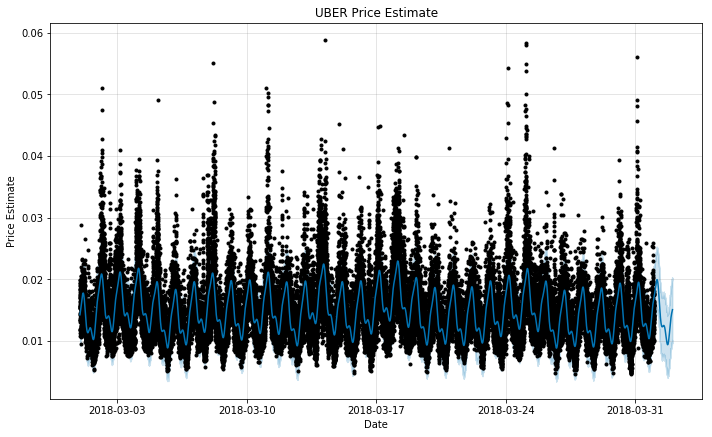

In [22]:
uber_prophet.plot(uber_forecast, xlabel = 'Date', ylabel = 'Price Estimate')
plt.title('UBER Price Estimate')

uberPOOL Price Estimate with __one day forecast__ into the future.

Text(0.5,1,'LYFT Price Estimate')

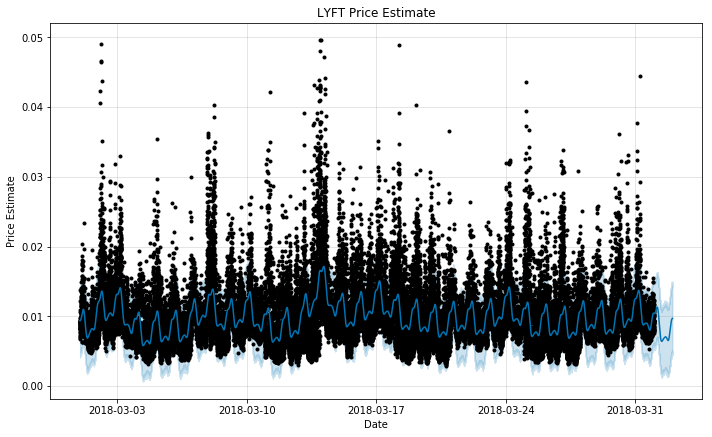

In [23]:
lyft_prophet.plot(lyft_forecast, xlabel = 'Date', ylabel = 'Price Estimate')
plt.title('LYFT Price Estimate')

Lyft Line Price Estimate with __one day forecast__ into the future.

### Changepoint Prior Scaling

When creating the prophet models, I set the __changepoint prior__ to the default value of 0.05. This hyperparameter is used to control how __sensitive__ the trend is to changes, with a higher value being more sensitive and a lower value less sensitive. This value is used to combat one of the most fundamental trade-offs in machine learning: _bias vs. variance_.

If we fit too closely to our training data, called _overfitting_, we have too much variance and our model will not be able to generalize well to new data. On the other hand, if our model does not capture the trends in our training data it is underfitting and has too much bias. When a model is underfitting, increasing the changepoint prior allows more flexibility for the model to fit the data, and if the model is overfitting, decreasing the prior limits the amount of flexibility. The effect of the changepoint prior scale can be illustrated by graphing predictions made with a range of values.

The higher the changepoint prior scale, the more flexible the model and the closer it fits to the training data. This may seem like exactly what we want, but learning the training data too well can lead to overfitting and an inability to accurately make predictions on new data. We therefore need to find the right balance of fitting the training data and being able to generalize to new data. As ride-sharing price estimates vary from day-to-day, and we want our model to capture this, we increased the flexibility after experimenting with a range of values.


In [24]:
# for loop to test out several changepoint prior scalings
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(changepoint_prior_scale=changepoint)
    model.fit(df2)
    # creating future dataframe named future with same periods and frequency
    future = model.make_future_dataframe(periods=1440, freq='T')
    future = model.predict(future)
    
    df2[changepoint] = future['yhat']

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Text(0.5,1,'Effect of Changepoint Prior Scale')

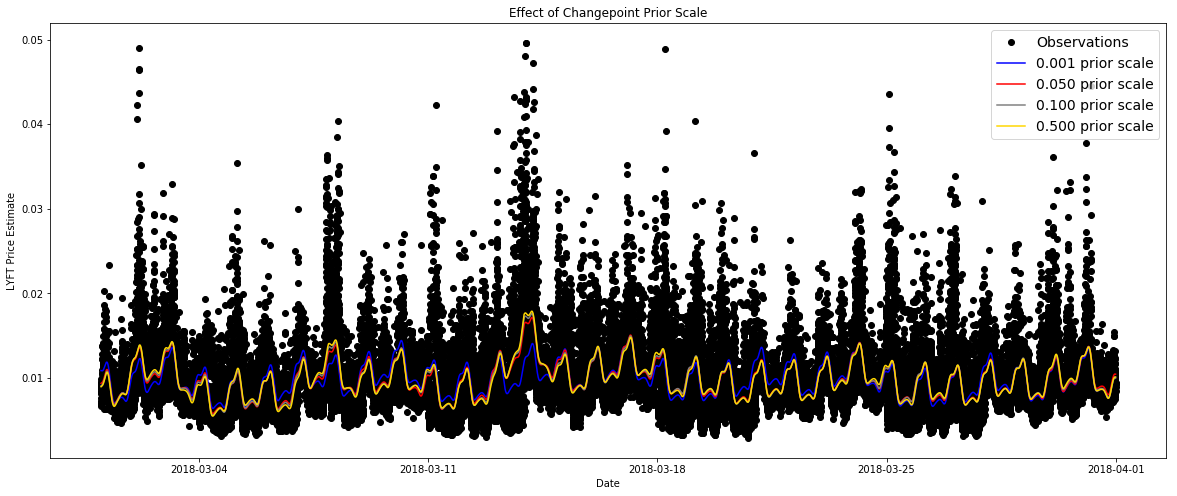

In [25]:
# Create the plot for visualizing different changepoint parameters
plt.figure(figsize=(20, 8))

# Actual observations
plt.plot(df2['ds'], df2['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(df2['ds'], df2[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date')
plt.ylabel('LYFT Price Estimate')
plt.title('Effect of Changepoint Prior Scale')

In [26]:
uber_prophet.changepoints[:10]

1422    2018-03-02 00:17:00
2844    2018-03-03 00:00:00
4266    2018-03-03 23:44:00
5688    2018-03-04 23:30:00
7109    2018-03-05 23:13:00
8531    2018-03-06 22:59:00
9953    2018-03-07 22:47:00
11375   2018-03-08 22:32:00
12797   2018-03-09 22:16:00
14219   2018-03-10 22:00:00
Name: ds, dtype: datetime64[ns]

In [27]:
lyft_prophet.changepoints[:10]

1422    2018-03-02 00:17:00
2844    2018-03-03 00:00:00
4266    2018-03-03 23:44:00
5688    2018-03-04 23:30:00
7109    2018-03-05 23:13:00
8531    2018-03-06 22:59:00
9953    2018-03-07 22:47:00
11375   2018-03-08 22:32:00
12797   2018-03-09 22:16:00
14219   2018-03-10 22:00:00
Name: ds, dtype: datetime64[ns]

### Trends and Patterns

The last step of the analysis is to look at the overall trend and patterns. Prophet allows us to easily visualize the overall trend and the component patterns. But first we need to merge Uber and Lyft's dataframes for Prophet to work its magic!

In [28]:
uber_names = ['uber_%s' % column for column in uber_forecast.columns]
lyft_names = ['lyft_%s' % column for column in lyft_forecast.columns]

# Dataframes to merge
merge_uber_forecast = uber_forecast.copy()
merge_lyft_forecast = lyft_forecast.copy()

# Rename the columns
merge_uber_forecast.columns = uber_names
merge_lyft_forecast.columns = lyft_names

In [29]:
# Merge the two datasets
forecast = pd.merge(merge_uber_forecast, merge_lyft_forecast, how = 'inner', left_on = 'uber_ds', right_on = 'lyft_ds')

# Rename date column
forecast = forecast.rename(columns={'uber_ds': 'Date Time'}).drop('lyft_ds', axis=1)
forecast.head()

,Date Time,uber_trend,uber_trend_lower,uber_trend_upper,uber_yhat_lower,uber_yhat_upper,uber_daily,uber_daily_lower,uber_daily_upper,uber_seasonal,...,lyft_seasonal,lyft_seasonal_lower,lyft_seasonal_upper,lyft_seasonalities,lyft_seasonalities_lower,lyft_seasonalities_upper,lyft_weekly,lyft_weekly_lower,lyft_weekly_upper,lyft_yhat
0,2018-03-01 00:00:00,0.012698,0.012698,0.012698,0.009374,0.019248,0.002267,0.002267,0.002267,0.001586,...,0.001778,0.001778,0.001778,0.001778,0.001778,0.001778,0.000270,0.000270,0.000270,0.009361
1,2018-03-01 00:01:00,0.012699,0.012699,0.012699,0.009377,0.019523,0.002279,0.002279,0.002279,0.001597,...,0.001778,0.001778,0.001778,0.001778,0.001778,0.001778,0.000270,0.000270,0.000270,0.009363
2,2018-03-01 00:02:00,0.012701,0.012701,0.012701,0.009826,0.019181,0.002290,0.002290,0.002290,0.001609,...,0.001778,0.001778,0.001778,0.001778,0.001778,0.001778,0.000269,0.000269,0.000269,0.009364
3,2018-03-01 00:03:00,0.012703,0.012703,0.012703,0.009448,0.019608,0.002302,0.002302,0.002302,0.001621,...,0.001778,0.001778,0.001778,0.001778,0.001778,0.001778,0.000269,0.000269,0.000269,0.009366
4,2018-03-01 00:04:00,0.012704,0.012704,0.012704,0.009358,0.019528,0.002313,0.002313,0.002313,0.001633,...,0.001778,0.001778,0.001778,0.001778,0.001778,0.001778,0.000268,0.000268,0.000268,0.009368


Text(0.5,1,'UBER vs. LYFT Trend')

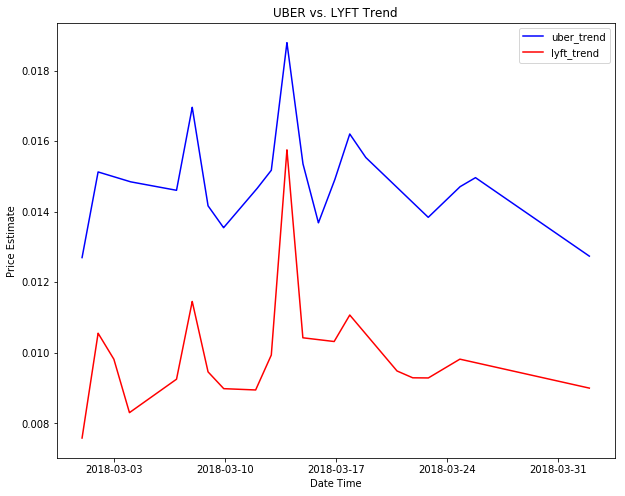

In [30]:
# Visualize Trend Only and the Forecast
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date Time'], forecast['uber_trend'], 'b-')
plt.plot(forecast['Date Time'], forecast['lyft_trend'], 'r-')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Price Estimate')
plt.title('UBER vs. LYFT Trend')

Text(0.5,1,'UBER vs. LYFT Estimate')

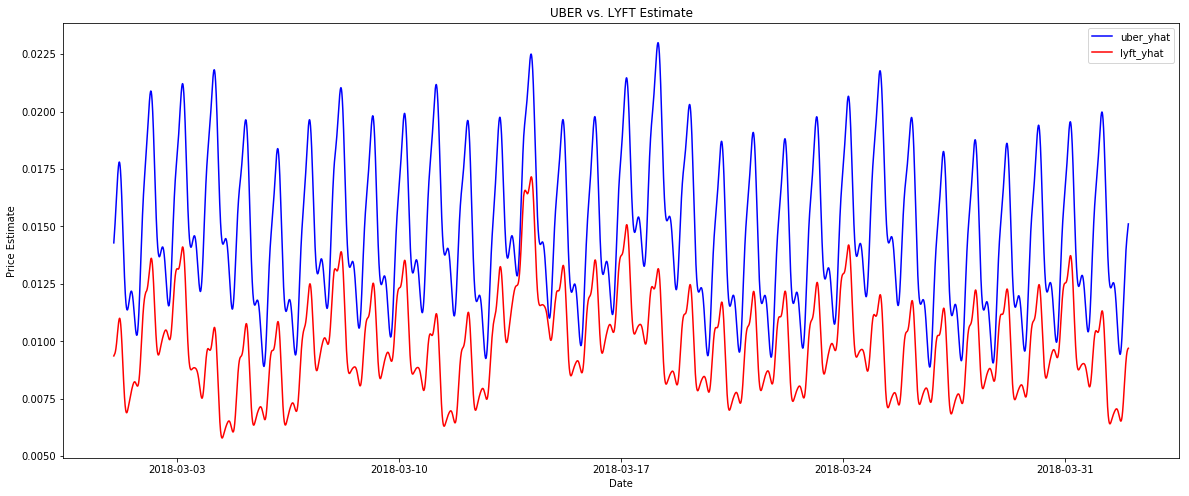

In [32]:
plt.figure(figsize=(20, 8))
plt.plot(forecast['Date Time'], forecast['uber_yhat'], 'b-')
plt.plot(forecast['Date Time'], forecast['lyft_yhat'], 'r-')
plt.legend(); plt.xlabel('Date')
plt.ylabel('Price Estimate')
plt.title('UBER vs. LYFT Estimate')

Text(0.5,1,'Price Prediction for UBER and LYFT')

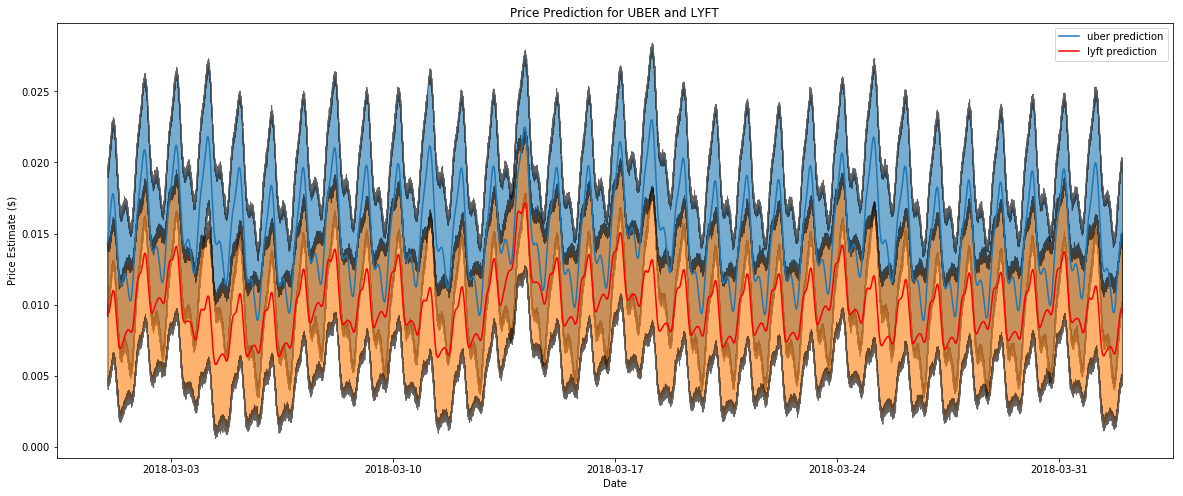

In [33]:
# Create subplots to set figure size
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Plot estimate
ax.plot(forecast['Date Time'], forecast['uber_yhat'], label = 'uber prediction')

# Plot uncertainty values
ax.fill_between(forecast['Date Time'].dt.to_pydatetime(), forecast['uber_yhat_upper'], forecast['uber_yhat_lower'], alpha=0.6, edgecolor = 'k')

# Plot estimate and uncertainty for lyft
ax.plot(forecast['Date Time'], forecast['lyft_yhat'], 'r', label = 'lyft prediction')
ax.fill_between(forecast['Date Time'].dt.to_pydatetime(), forecast['lyft_yhat_upper'], forecast['lyft_yhat_lower'], alpha=0.6, edgecolor = 'k')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price Estimate ($)')
plt.title('Price Prediction for UBER and LYFT')

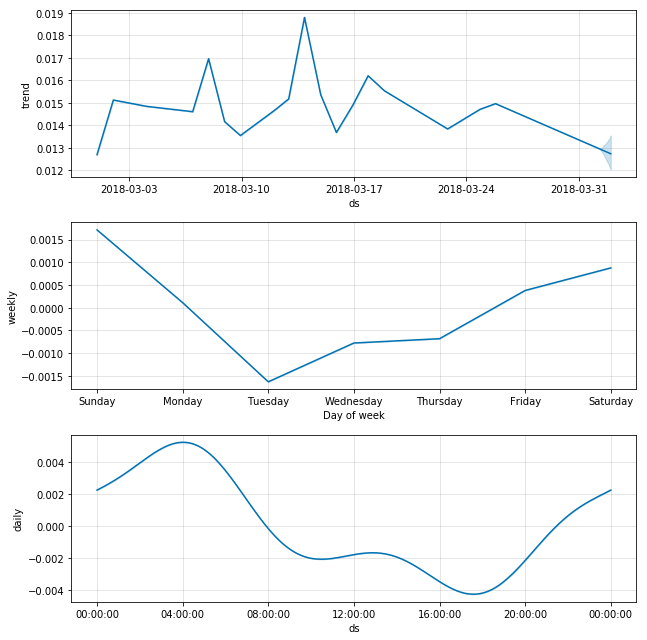

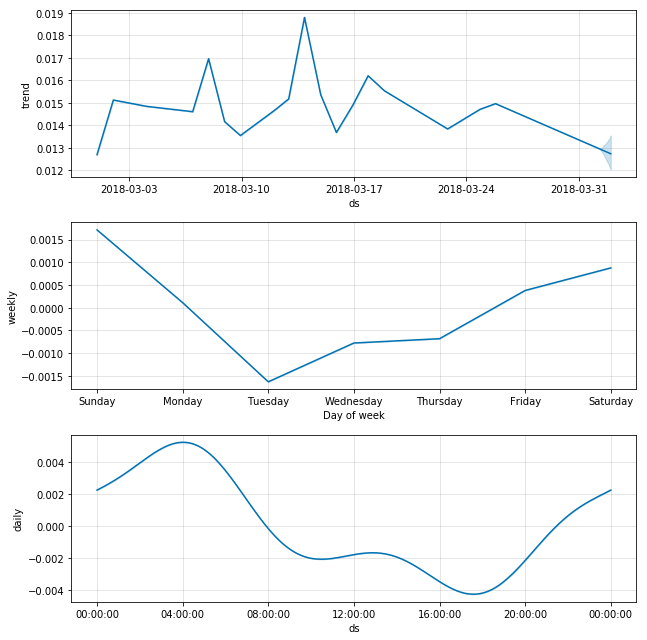

In [34]:
uber_prophet.plot_components(uber_forecast)

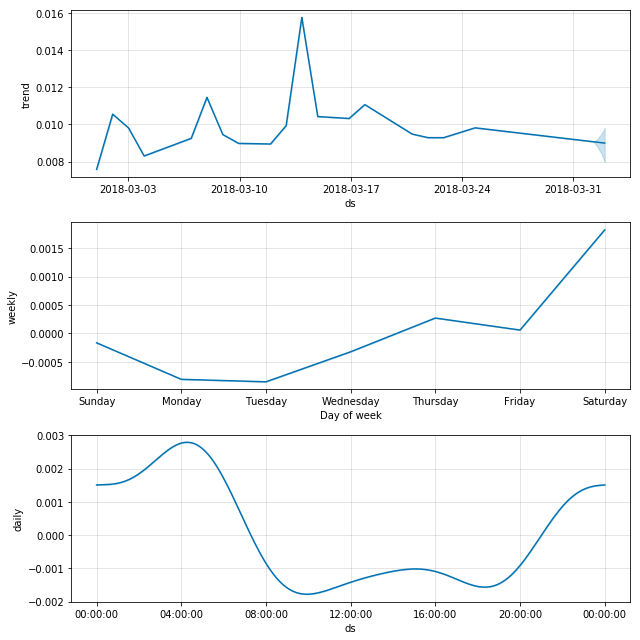

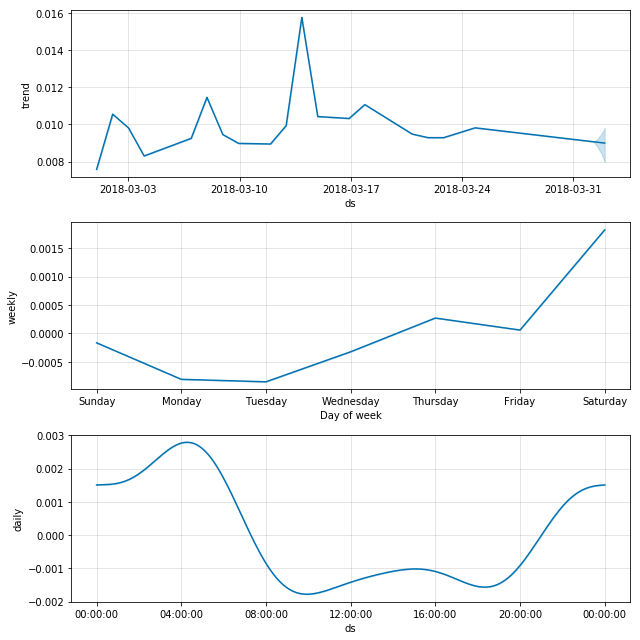

In [35]:
lyft_prophet.plot_components(lyft_forecast)

### Conclusion

Lyft is generally cheaper than Uber. UberPOOL is generally more expensive during the weekends, especially on Sundays. Its daily trend shows a price surge between 2:00AM and 6:00AM. Lyft Line is generally more expensive during the weekends as well, but especially on Saturdays. Its daily trend shows a price surge between 3:00AM and 5:00AM, which is a shorter window compared to uberPOOL.

![thank you for reading](https://steemit-production-imageproxy-web.s3.amazonaws.com/U5dsCyY1nqNs8vZHBQusqgr5vmHcgrJ)

__Reference__: __[Time Series Analysis in Python: An Introduction](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a)__

__Inspired by__: __[Facebook's GitHub repo](https://github.com/facebook/prophet/tree/v0.2)__

The code in the document by __Facebook__ is licensed under the __[BSD License](https://opensource.org/licenses/BSD-3-Clause)__.

[Back to the Top!](#Time-Series-Analysis-with-Facebook-Prophet)